In [1]:
import numpy as np
import pImpactR as impact
import matplotlib.pyplot as plt
import os
int = np.vectorize(int)
from copy import deepcopy as copy

In [2]:
NTURN = np.array([128,256])
nBatch = 32

NL_L = 1.8
NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3034496449165134

In [3]:
beam, lattice = impact.readInputFile('../test_IOTA.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

betx = NL_L/np.sin(2.0*np.pi*NL_nu)
alfx = np.tan(np.pi*NL_nu)

reading ImpactZ input file (../test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
print(betx,alfx)

1.9065054393933862 1.4082261727304293


In [5]:
def getTBT(iBatch):
    iTBT = {}
    TBT = {}
    X = {}
    Y = {}
    Npt = {}

    for nturn in NTURN:
        os.chdir('./'+str(nturn))
        iTBT[nturn],TBT[nturn] = impact.readTBT(nturn+iBatch,ke,mass,freq)
        TBT[nturn] = TBT[nturn][:,:4,:]
        Npt[nturn] = len(iTBT[nturn])
        iTBT[-nturn],TBT[-nturn] = impact.readTBT(100000+nturn+iBatch,ke,mass,freq)
        TBT[-nturn] = TBT[-nturn][:,:4,:]
        Npt[-nturn] = len(iTBT[-nturn])
        os.chdir('../')
        
    for i in range(len(NTURN)):
        nturn = NTURN[i]
        npt = len(iTBT[nturn])
        X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)

        iturn = 0
        for j in range(i+1):
            jturn = NTURN[j]
            itmp = np.in1d(iTBT[jturn],iTBT[nturn])
            tmp = TBT[jturn][:,:,itmp]
            X[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
            Y[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
            iturn = jturn


            
        for i in range(len(NTURN)):
            nturn = NTURN[i]
            npt = len(iTBT[-nturn])
            X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
            Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)
            tmp = TBT[-nturn][::-1,:4,:]
            X[-nturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
            Y[-nturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))

            iturn = 0
            for j in range(i+1):
                jturn = NTURN[j]
                itmp = np.in1d(iTBT[jturn],iTBT[-nturn])
                tmp = TBT[jturn][:,:,itmp]
                X[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
                Y[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
                iturn = jturn
    return X,Y

In [6]:
def getDiffMultiTurns(X,Y):
    Adiff = {}

    for nturn in NTURN:
#         print('X[nturn][0].shape=',X[nturn][0].shape)
        Xdiff = np.abs(X[nturn][0]-X[-nturn][0])**2
        Ydiff = np.abs(Y[nturn][0]-Y[-nturn][0])**2
        Adiff[nturn] = np.sqrt(Xdiff + Ydiff)
        Adiff[nturn] = np.log10(Adiff[nturn])
        print('Adiff[nturn].max()',Adiff[nturn].max())

    return Adiff

In [7]:
def reduceX_to_initial(X):
    for k,v in X.items():
        X[k] = np.real(X[k][0,:])

def concantenate_batches(fin,fout):
    for k,v in fout.items():
        fout[k] = np.concatenate((v, fin[k]), axis=None)

In [8]:
for i in range(nBatch):
    X_,Y_ = getTBT(i+1)
    if i==0:
        for n in NTURN:
            print( n,X_[ n].shape)
            print(-n,X_[-n].shape)
            nturn = 256
            iturn = 126
            ipt = 100
            print(X_[n][iturn,ipt]-X_[-n][iturn,ipt])
            
    Diff_ = getDiffMultiTurns(X_,Y_)
    reduceX_to_initial(X_)
    reduceX_to_initial(Y_)
    if(i==0):
        X   = X_.copy()
        Y   = Y_.copy()
        Diff= Diff_.copy()
    else:
        concantenate_batches(X_,X)
        concantenate_batches(Y_,Y)
        concantenate_batches(Diff_,Diff)

128 (128, 16005)
-128 (128, 16005)
(-3.020167449463429e-12-1.8311879790289254e-11j)
256 (256, 16005)
-256 (256, 16005)
(-1.9087437186371403e-10-5.968076588480642e-10j)
Adiff[nturn].max() -7.828163235105493
Adiff[nturn].max() -6.983140052915247
Adiff[nturn].max() -7.756532511075111
Adiff[nturn].max() -6.864809028164322
Adiff[nturn].max() -7.768705030286555
Adiff[nturn].max() -7.024845008562266
Adiff[nturn].max() -8.031494414824731
Adiff[nturn].max() -7.107785000295449
Adiff[nturn].max() -7.866292465421392
Adiff[nturn].max() -6.87364364937645
Adiff[nturn].max() -7.874997240515415
Adiff[nturn].max() -6.799970118519711
Adiff[nturn].max() -7.936629845215326
Adiff[nturn].max() -6.581659686512965
Adiff[nturn].max() -7.695803004085197
Adiff[nturn].max() -7.336993986759342
Adiff[nturn].max() -7.752376525398814
Adiff[nturn].max() -6.450210283929895
Adiff[nturn].max() -7.7111657068726345
Adiff[nturn].max() -6.477028566270419
Adiff[nturn].max() -7.7590309111434115
Adiff[nturn].max() -7.12124816598

In [9]:
n=128
xmax = np.max(np.abs(X[n]))
ymax = np.max(np.abs(Y[n]))

nx = 50*2*2  #Must be even number to have x=0 an grid point
ny = 50*2*2

dx = 2*xmax/nx
dy = 2*ymax/ny

xMsh = np.linspace(-xmax-dx,xmax+dx, nx+3)
yMsh = np.linspace(-ymax-dy,ymax+dy, ny+3)

In [10]:
X.keys()

dict_keys([128, -128, 256, -256])

In [11]:
def getMeshInfo(X,Y,xMsh,yMsh,dx,dy):
    nx=len(xMsh)
    ny=len(yMsh)
    gZ = np.zeros([nx,ny])
    gZmax = -20*np.ones([nx,ny])
    gN = np.zeros([nx,ny])
    fX,fY = (X+xmax+dx)/dx, (Y+ymax+dy)/dy
    iX,iY = int(fX), int(fY)
    fX,fY = fX-iX, fY-iY
    iX,iY = iX, iY
    
    for i in range(len(X)):
        gZ[iX[i]  ,iY[i]  ] = gZ[iX[i]  ,iY[i]  ] +Diff[n][i]*(1.0-fY[i])*(1.0-fX[i])
        gZ[iX[i]  ,iY[i]+1] = gZ[iX[i]  ,iY[i]+1] +Diff[n][i]*(    fY[i])*(1.0-fX[i])
        gZ[iX[i]+1,iY[i]+1] = gZ[iX[i]+1,iY[i]+1] +Diff[n][i]*(    fY[i])*(    fX[i])
        gZ[iX[i]+1,iY[i]  ] = gZ[iX[i]+1,iY[i]  ] +Diff[n][i]*(1.0-fY[i])*(    fX[i])
        gN[iX[i]  ,iY[i]  ] = gN[iX[i]  ,iY[i]  ] +           (1.0-fY[i])*(1.0-fX[i])
        gN[iX[i]  ,iY[i]+1] = gN[iX[i]  ,iY[i]+1] +           (    fY[i])*(1.0-fX[i])
        gN[iX[i]+1,iY[i]+1] = gN[iX[i]+1,iY[i]+1] +           (    fY[i])*(    fX[i])
        gN[iX[i]+1,iY[i]  ] = gN[iX[i]+1,iY[i]  ] +           (1.0-fY[i])*(    fX[i])
        
        
    for i in range(len(X)):
        test = Diff[n][i]
        if gZmax[iX[i],iY[i]] < test:
            gZmax[iX[i],iY[i]] = test
    
        
    for i in range(1,int(ny/2)):
        gZmax[:,int(ny/2)-i]=gZmax[:,int(ny/2)+i]
        gZ[:,int(ny/2)-i]=gZ[:,int(ny/2)+i]
        gN[:,int(ny/2)-i]=gN[:,int(ny/2)+i]

    gN[:,int(ny/2)]=2*gN[:,int(ny/2)]
    gZ[:,int(ny/2)]=2*gZ[:,int(ny/2)]


#     args = np.argwhere(gN>0.1)
#     gZ[args] = gZ[args]/gN[args]        
    return gZ,gN,gZmax

In [12]:
def msh2p(xlist,ylist,gZ,gN,gZmanx):
    ny,nx = gN.shape
    pX = np.zeros(nx*ny)
    pY = np.zeros(nx*ny)
    pZ = np.zeros(nx*ny)
    pZmax = np.zeros(nx*ny)
    n=0
    for ix in range(nx):
        for iy in range(ny):
            if gN[ix,iy]>0.1:
                pX[n] = xlist[ix]
                pY[n] = ylist[iy]
                pZ[n] = gZ[ix,iy]/gN[ix,iy]
                pZmax[n] = gZmax[ix,iy]
#                 pZ[n] = gN[ix,iy]
                n=n+1
    pX=pX[:n]
    pY=pY[:n]
    pZ=pZ[:n]
    pZmax=pZmax[:n]
    return pX,pY,pZ,pZmax

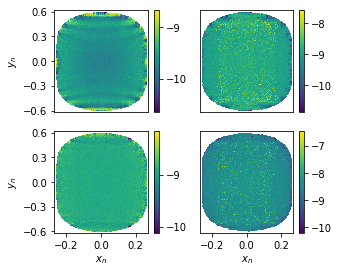

In [13]:
fig = plt.figure(figsize=[6.4*0.75,5.2*0.75])

for i,n in enumerate(NTURN):
    gZ,gN,gZmax = getMeshInfo(X[n],Y[n],xMsh,yMsh,dx,dy)
    pX,pY,pZ,pZmax = msh2p(xMsh,yMsh,gZ,gN,gZmax)
    
    
    plt.subplot(2,2,2*i+1)
    f1=plt.scatter(pX,pY,c=pZ,s=1,marker='s')
    plt.xlim(-xmax*1.05,xmax*1.05)
    plt.ylim(-ymax*1.05,ymax*1.05)
    if i==1:
        plt.xticks([-0.2,0,0.2])
    else:
        plt.xticks([])
    plt.yticks([-0.6,-0.3,0,0.3,0.6])
    if i==1:
        plt.xlabel('$x_n$')  
    plt.ylabel('$y_n$')
    plt.colorbar(f1, ticks=[-7,-8,-9,-10,-11])
    
    
    plt.subplot(2,2,2*i+2)
    Index = np.argwhere(pZmax != -20)
    f1=plt.scatter((pX[Index]+0.5*dx),(pY[Index]+0.5*dy),c=pZmax[Index],s=1,marker='s')
    plt.xlim(-xmax*1.05,xmax*1.05)
    plt.ylim(-ymax*1.05,ymax*1.05)
    plt.yticks([])
    if i==1:
        plt.xticks([-0.2,0,0.2])
    else:
        plt.xticks([])
    if i==1:
        plt.xlabel('$x_n$') 
    plt.colorbar(f1, ticks=[-7,-8,-9,-10,-11])

    
plt.tight_layout()
plt.savefig('First256turns.FB.4Dto2D.turn='+str(NTURN[0])+'-'+str(NTURN[-1])+'.png',dpi=180)

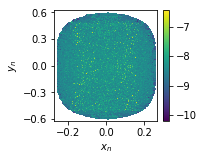

In [15]:
fig = plt.figure(figsize=[6.4*0.45,5.2*0.45])
n=NTURN[-1]
gZ,gN,gZmax = getMeshInfo(X[n],Y[n],xMsh,yMsh,dx,dy)
pX,pY,pZ,pZmax = msh2p(xMsh,yMsh,gZ,gN,gZmax)

Index = np.argwhere(pZmax != -20)
f1=plt.scatter((pX[Index]+0.5*dx),(pY[Index]+0.5*dy),c=pZmax[Index],s=1,marker='s')
plt.xlim(-xmax*1.05,xmax*1.05)
plt.ylim(-ymax*1.05,ymax*1.05)
plt.xticks([-0.2,0,0.2])
plt.yticks([-0.6,-0.3,0,0.3,0.6])
plt.xlabel('$x_n$')  
plt.ylabel('$y_n$')
plt.colorbar(f1, ticks=[-7,-8,-9,-10,-11])
    
plt.tight_layout()
plt.savefig('First256turns.FB.4Dto2D.turn='+str(NTURN[-1])+'.png',dpi=180)
plt.savefig('First256turns.FB.4Dto2D.turn='+str(NTURN[-1])+'.eps',dpi=180)